## 1. Library

In [ ]:
import sys
 
# setting path
sys.path.append('..')

import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

from mne.parallel import parallel_func
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands
from mne.preprocessing import corrmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

## 2. Read a RN App, converted pkl file

In [2]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'

timestamp_fixer_path = f"{data_dir}annotated/fit_timestamp_adjuster.pkl"

if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]

ts_fixer = pickle.load(open(timestamp_fixer_path, 'rb')) # features == 'processed_trial_duration',  'processed_trial_duration_1', 'lsl_timestamps'

# all_dfs = pd.read_excel("output/all_results_cleaned.xlsx")
# all_dfs = clean_up_adadrive_trials(all_dfs)

save_data_pkl = True # save data into pickle files
save_ica_plts = True # save ICA components plots
epoch_raw_eeg = True # epoching raw data
motor_events = False
rs = 64 # random state

interrupted_sessions = [(13,1), (22,1)]
# remove_sessions = [(13,1),(15,1),(22,1)]
remove_sessions = [(13,1),(15,1),(22,1),(22,102)]

## 3. Define Processing and Classification Functions

### EEG Features Extraction

In [3]:
def eeg_features(all_data, data_type, selected_chans = False, features = 'all', 
                 label_source = 'spoken_difficulty_encoded'):
    
    if data_type == 'processed':
        first_electrode_column_name = "Fp1_4-8_Hz_Power"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy"
        autoreject_column_name = "autorejected"
    elif data_type == 'raw':
        first_electrode_column_name = "Fp1_4-8_Hz_Power_raw"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy_raw"
        autoreject_column_name = "autorejected_raw"
        
    first_electrode_idx = all_data.columns.get_loc(first_electrode_column_name)
    last_electrode_idx = all_data.columns.get_loc(last_electrode_column_name)

    left_pupil_diameter_idx = all_data.columns.get_loc("Left Pupil Diameter")
    right_pupil_diameter_idx = all_data.columns.get_loc("Right Pupil Diameter")

    # with autoreject
    valid_trial = (all_data[label_source].notnull()) & (all_data[autoreject_column_name] == False)
    
    all_eeg_features = all_data.iloc[:,first_electrode_idx:last_electrode_idx+1] # all features in cleaned up data
    pupil_diameter = all_data.iloc[:,left_pupil_diameter_idx:right_pupil_diameter_idx+1]
    
    if features != 'all': 
        eeg_features = all_eeg_features.loc[:, all_eeg_features.columns.str.contains(features)]
    else:
        eeg_features = all_eeg_features
        
    # if features == 'higuchi': eeg_features = all_eeg_features.loc[:, all_eeg_features.columns.str.contains('Higuchi_FD')]
    # if features == 'sampEn': eeg_features = all_eeg_features.loc[:, all_eeg_features.columns.str.contains('Sample_entropy')]
    # if features == 'horjth': eeg_features = all_eeg_features.loc[:, 
    #                                         all_eeg_features.columns.str.contains('Hjorth_Activity|Hjorth_Mobility|Hjorth_Complexity')]

    data_features = np.asarray(eeg_features.join(pupil_diameter)[valid_trial])
    data_labels = np.asarray(all_data[valid_trial][label_source])

    
    if selected_chans:
        # selected channel: ‘FC3’, ‘FC1’, ‘FCz’, ‘FC2’, ‘FC4’, ‘AF3’, ‘AFz’, ‘AF4’, ‘F3’, ‘F1’, ‘Fz’, ‘F2’, ‘F4’]
        # selected_channel_eeg_features = all_eeg_features.loc[:,
        #                         all_eeg_features.columns.str.contains('AF4|F6|F4|AF8|AF3|F5|F3|AF7|FC2|FC4|FC4|FC1|FC3|PO4|P4|P6|P3|P5|PO3')]
        eeg_features = all_eeg_features.loc[:,
                       all_eeg_features.columns.str.contains('FC3|FC1|FCz|FC2|FC4|AF3|AFz|AF1|F3|F1|Fz|F2|F4')]
        data_features=np.asarray(eeg_features.join(pupil_diameter)[valid_trial])
        data_labels=np.asarray(all_data[valid_trial][label_source])
    
    return eeg_features, data_features, data_labels

### EEG Features normalization

In [4]:
def feature_normalization(proc_feature, processed_labels, raw_feature, raw_labels, train_percentage=0.8):
    
    # Remove rows with invalid pupil diameter
    if (raw_feature == None) and (sum(sum(np.isnan(proc_feature))) > 0):
        invalid_pupil_proc = np.argwhere(np.any(np.isnan(proc_feature) == True, axis=1))
        proc_feature_corrected = np.delete(proc_feature, invalid_pupil_proc, axis=0)
        proc_labels_corrected = np.delete(processed_labels, invalid_pupil_proc, axis=0)
        
        raw_feature_corrected = raw_feature
        raw_labels_corrected = raw_labels
    
    elif not (raw_feature == None) and (sum(sum(np.isnan(raw_feature))) > 0 or sum(sum(np.isnan(proc_feature))) > 0):

        invalid_pupil_proc = np.argwhere(np.any(np.isnan(proc_feature) == True, axis=1))
        proc_feature_corrected = np.delete(proc_feature, invalid_pupil_proc, axis=0)
        proc_labels_corrected = np.delete(processed_labels, invalid_pupil_proc, axis=0)

        invalid_pupil_raw = np.argwhere(np.any(np.isnan(raw_feature) == True, axis=1))
        raw_feature_corrected = np.delete(raw_feature, invalid_pupil_raw, axis=0)
        raw_labels_corrected = np.delete(raw_labels, invalid_pupil_raw, axis=0)

    else:
        raw_feature_corrected = raw_feature
        raw_labels_corrected = raw_labels
        proc_feature_corrected = proc_feature
        proc_labels_corrected = processed_labels

    # Data Split
    if raw_feature == None: 
        raw_train_norm = raw_test_norm = y_train_raw = y_test_raw = None
    else:
        x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(raw_feature_corrected, raw_labels_corrected, 
                                                                            train_size = train_percentage, random_state=rs)
        # fit scaler on training data (fitting scaler on ONLY training data prevent data leakage)
        norm_raw = MinMaxScaler().fit(x_train_raw)
        # Normalize training and testing data 
        raw_train_norm = norm_raw.transform(x_train_raw)
        raw_test_norm = norm_raw.transform(x_test_raw)
    
    
    x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(proc_feature_corrected, proc_labels_corrected, 
                                                                            train_size = train_percentage, random_state=rs)
    
    norm_proc= MinMaxScaler().fit(x_train_proc)
    proc_train_norm = norm_proc.transform(x_train_proc)
    proc_test_norm = norm_proc.transform(x_test_proc)

    return raw_train_norm, raw_test_norm, proc_train_norm, proc_test_norm, y_train_raw, y_test_raw, y_train_proc, y_test_proc


### Classification Function

In [5]:
def trial_classification(train_data, test_data, train_label, test_label, 
                                     classfier, data_type = None, save_plots = True):

    if classfier == 'logistic':

        logreg = LogisticRegression(solver="liblinear", penalty = 'l2', random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)
        
        importance = logreg.coef_[0]

    if classfier == 'svm':

        svm_classifer = SGDClassifier(penalty = 'l1',l1_ratio=1, random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)
        
        importance = svm_classifer.coef_[0]

    if classfier == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0
        
    if classfier == 'random_forest':
        random_forest = RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state = rs, 
                                               bootstrap=True, class_weight = 'balanced_subsample', 
                                               max_samples=None, n_jobs = -1).fit(train_data, train_label)
        
        score_train = random_forest.predict_proba(train_data)[:,1]
        score_test = random_forest.predict_proba(test_data)[:,1]
        
        train_pred = random_forest.predict(train_data)
        test_pred = random_forest.predict(test_data)
        
        importance = random_forest.feature_importances_

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    AUC_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    AUC_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    sns.set(font_scale=2)
    plt.style.use('seaborn-white')
    fig = plt.figure(figsize = [25,7])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(AUC_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(AUC_test))
    
    if save_plots:
        plt.savefig(f"../output/classification_result/{data_type}_data_Training_Testing_ROC_Curve.png", dpi=300)

    # plt.grid(visible=False)
    
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    
    fig_cnf = plt.figure(figsize = [20, 5])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)
    
    sns.heatmap(cnf_matrix_train, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    
    if save_plots:
        plt.savefig(f"../output/classification_result/{data_type}_data_Training_Testing_Confusion_Matrix.png", dpi=300)
    
    # Features Importance
    fig_importance = plt.figure(figsize = [10 ,3])
    axe = fig_importance.add_subplot(1,1,1)

    markerline, stemline, baseline = axe.stem([x for x in range(len(importance))], importance, 
                                              linefmt='k-',markerfmt='ko',basefmt='k.')
    plt.setp(stemline, linewidth = 1)
    plt.setp(markerline, markersize = 1)
    axe.set_xlabel("Feature")
    axe.set_ylabel("Importance")
    axe.set_title("Coefficient for Each Features")
    if save_plots:
        plt.savefig(f"../output/classification_result/{data_type}_data_coefficient.png")
    
    plt.show()
    
    return AUC_train, AUC_test, importance

## 4. Process, Save, and Load Data

### Process and Save All Data

In [6]:
# all_dfs = None

# ica_epochs_dict = {}
# ica_dict = {}
# eog_idx_dict = {}
# events_dict = {}

# for each_file in onlyfiles:
#     input_path = data_dir + each_file
    
#     sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
#     ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

#     if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
#     else: sbj = "sbj"+sbj_id
#     if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
#     else: ssn = "ssn"+ssn_no
    
#     if sbj+ssn == "sbj20ssn03":
#         ref_ica = None
#     else: 
#         ref_ica = ica_dict['sbj20ssn03']
    
#     with open(input_path, 'rb') as handle:
#         rns_data = pickle.load(handle)

#     ## Add metadata to data

#     for key in rns_data.keys():
#         rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

#     event_df = event_data_from_data(rns_data, interrupted_id_sessions=[(13,1), (22,1)])
#     event_df['trial_damage'] = event_df.damage.diff().fillna(0)
#     event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time

#     percent_missing = event_df.notnull().sum() / len(event_df)
#     summary_statistics = {}
#     summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
#     if 'chunk_timestamp' in percent_missing:
#         summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
#     else:
#         summary_statistics['chunk_success_rate'] = 0

#     # temporary fix for pilot phase where we had some incomplete data
#     if 'block_condition' not in event_df:
#         event_df['block_condition'] = 'practice'
#         event_df.loc[5:,'block_condition'] = 'voice'

#     event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
#                                                                           value=[1, 2, None])

#     # ecg
#     post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

#     # eye
#     # post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,pretrial_period=0,
#     #                                               posttrial_period=0,plot_frequency=20, plot_eye_snippet=40, classifiers=['NSLR'])
#     if 'Unity_ViveSREyeTracking' in rns_data:
#         post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,
#                                                       pretrial_period=0, posttrial_period=0, plot_frequency=20, 
#                                                       plot_eye_snippet=40, classifiers=['NSLR'])

#     # eeg
#     post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
#                                 run_autoreject=True, run_ica=True, save_raw_eeg = True, sbj_session = sbj+ssn, 
#                                 template_ica = ref_ica, analyze_pre_ica = True)
    
#     # motor
#     post_processed_event_df, turns_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
#                                                 plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)
#     if motor_events:
#         post_processed_event_df = turns_df
    
#     events_dict[sbj+ssn] = events
#     ica_epochs_dict[sbj+ssn] = epochs
#     ica_dict[sbj+ssn] = ica
#     eog_idx_dict[sbj+ssn] = eog_idx
    
#     # save data for later use
#     if save_data_pkl:
        
#         with open('../output/saved_files/pickle_files/all_events.pickle', 'wb') as handle_events:
#             pickle.dump(events_dict, handle_events, protocol=pickle.HIGHEST_PROTOCOL)
#         with open('../output/saved_files/pickle_files/ica_epochs.pickle', 'wb') as handle_ica_eps:
#             pickle.dump(ica_epochs_dict, handle_ica_eps, protocol=pickle.HIGHEST_PROTOCOL)
#         with open('../output/saved_files/pickle_files/ica.pickle', 'wb') as handle_ica:
#             pickle.dump(ica_dict, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
#         with open('../output/saved_files/pickle_files/eog_comp.pickle', 'wb') as handle_eog:
#             pickle.dump(eog_idx_dict, handle_eog, protocol=pickle.HIGHEST_PROTOCOL)

#     # save
#     post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
#     if not type(all_dfs)==pd.core.frame.DataFrame:
#         all_dfs = post_processed_event_df
#     else:
#         all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)
    

Creating RawArray with float64 data, n_channels=89, n_times=3399947
    Range : 0 ... 3399946 =      0.000 ...  1660.130 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.5s finished


Overwriting existing file.
Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 45.3s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
35 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 411 original time points ...
0 bad epochs dropped
Dropped 2 epochs: 13, 20
Adding metadata with 60 columns
35 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.1s finished


Overwriting existing file.
Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 32.2s.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
33 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.4s finished


Overwriting existing file.
Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 26.8s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 61 columns
32 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.4s finished


Overwriting existing file.
Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.8s.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 61 columns
11 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.5s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 24.9s.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
46 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 411 original time points ...
1 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.5s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 36.2s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
29 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 443.1s.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
29 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 411 original time points ...
0 bad e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj12ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.7s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
47 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 47 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.1s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 38.6s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
31 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.1s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 34.6s.
Median correlation with constructed map: 0.975
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
42 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.1s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.0s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
9 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.6s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
20 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 26.8s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
14 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 14 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj16ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.6s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
41 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.0s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj19ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 57.0s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.979
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
30 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.2s.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
49 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 49 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.1s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 18.7s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
34 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 411 original time points ...
1 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 20.6s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
19 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 19 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 28.3s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
13 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj21ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 48.2s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
32 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.9s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj13ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 24.1s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
27 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.9s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 22.3s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
35 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 411 original time points ...
1 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.3s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj20ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.2s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
20 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.9s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 390.3s.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 40 columns
25 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 411 original time points ...
0 bad e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj14ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.9s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
24 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj18ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.6s.
Median correlation with constructed map: 0.985
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Adding metadata with 60 columns
24 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 411 origin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.8s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn01_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj17ssn01_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.1s.
Median correlation with constructed map: 0.999
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
21 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 411 original time points ...
0 bad ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn02_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn02_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 29.4s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
36 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.2s finished


Writing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn03_eeg_filt_raw.fif
Closing /home/jupyter/mna/notebooks/../output/saved_files/raw_eeg/sbj23ssn03_eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 37.1s.
Median correlation with constructed map: 0.983
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Adding metadata with 60 columns
46 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 46 events and 411 original time points ...
1 bad ep

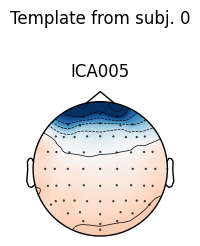

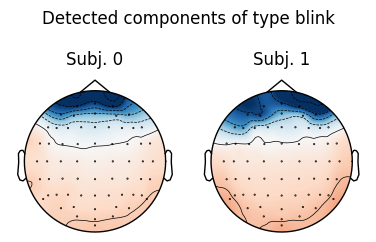

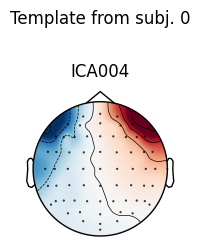

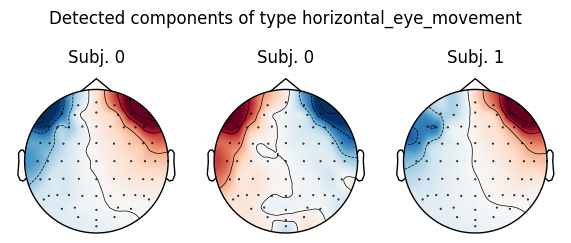

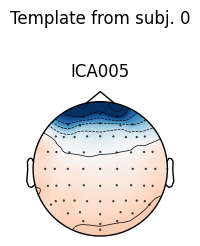

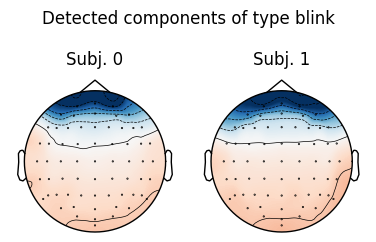

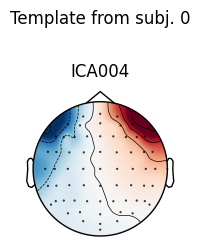

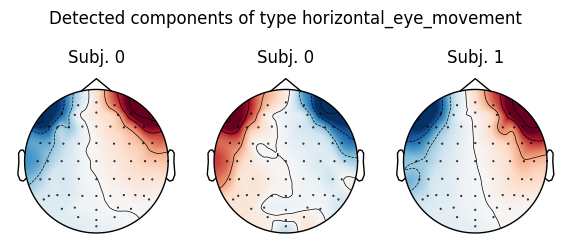

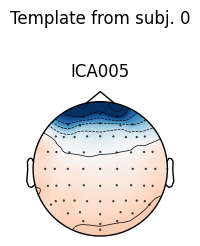

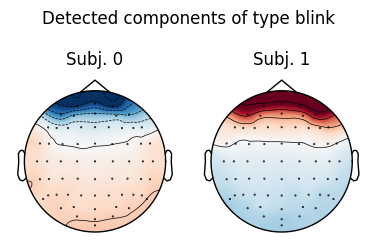

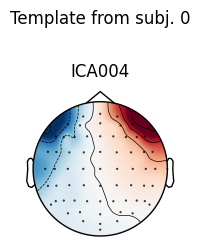

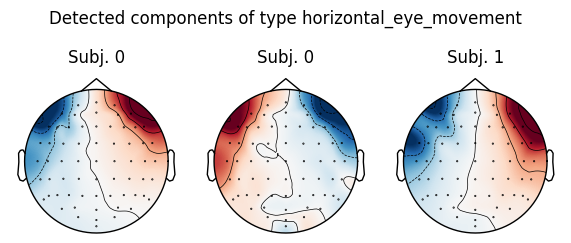

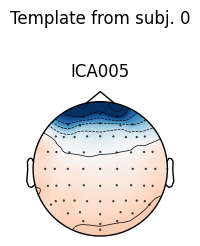

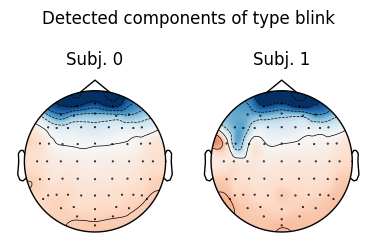

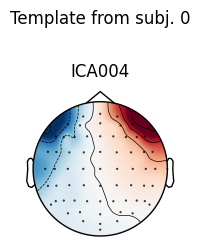

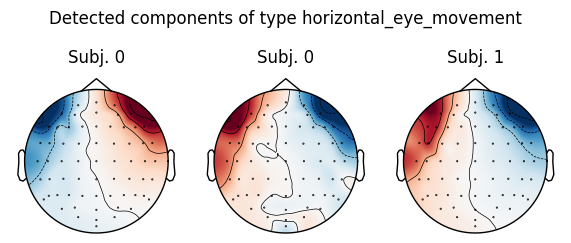

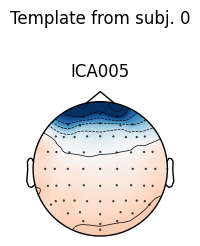

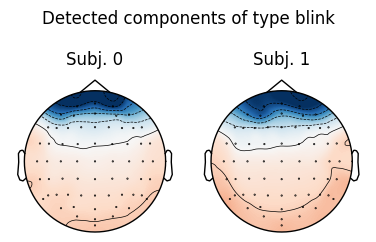

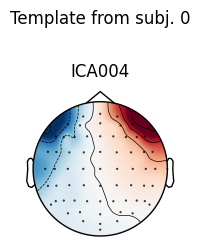

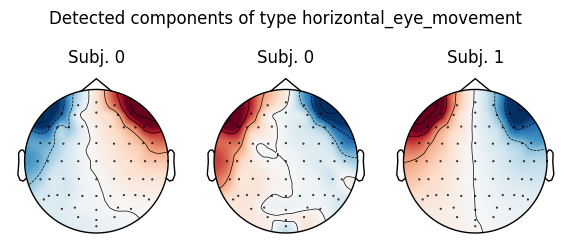

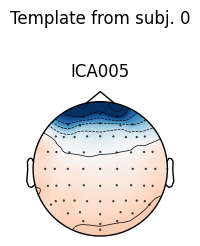

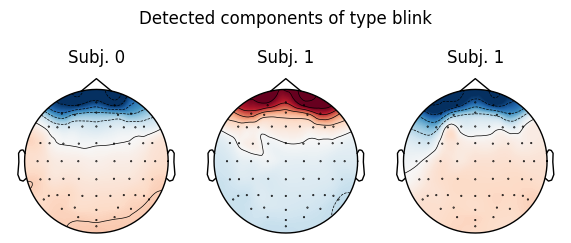

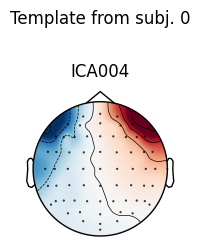

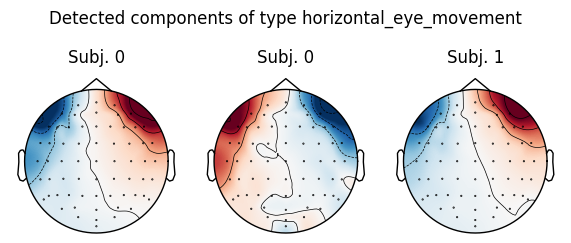

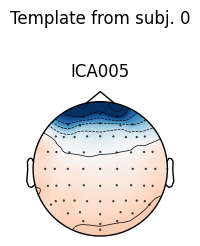

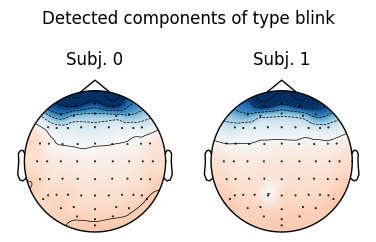

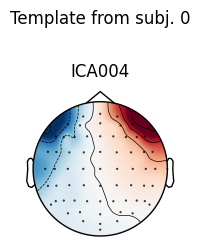

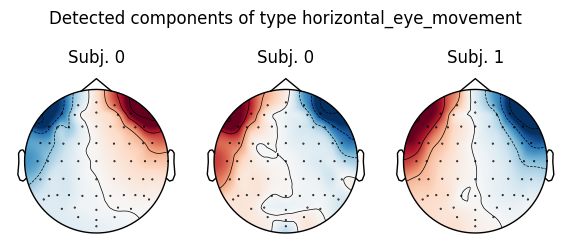

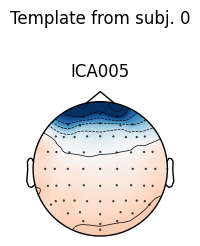

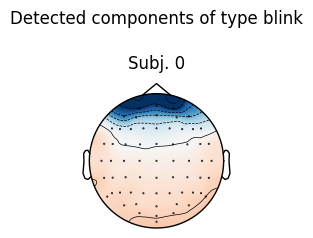

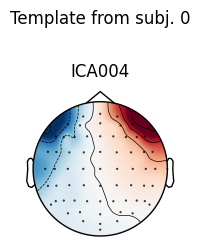

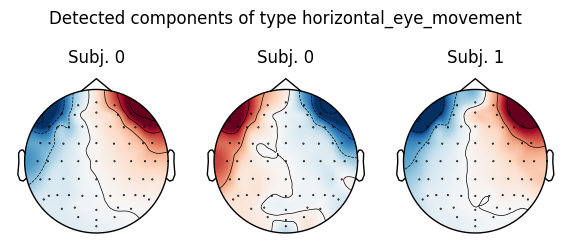

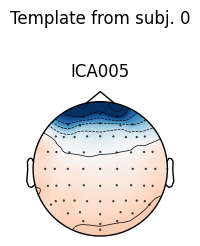

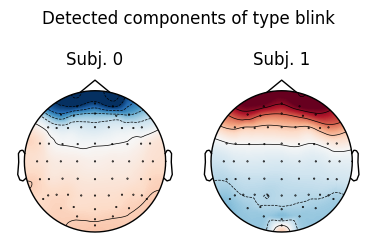

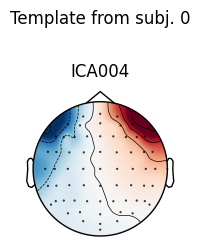

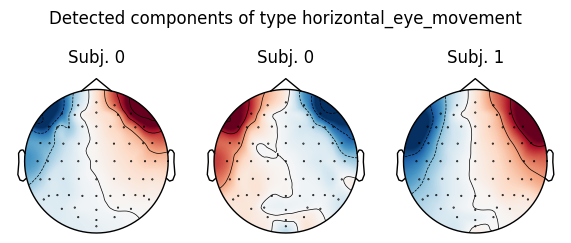

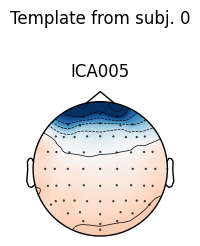

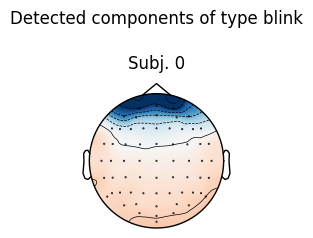

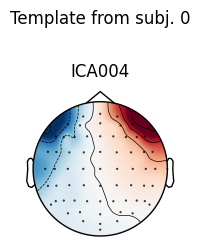

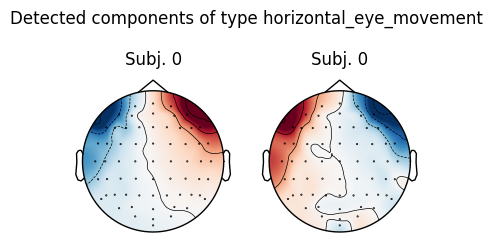

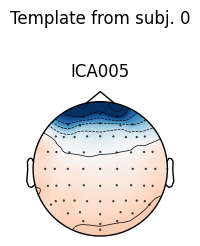

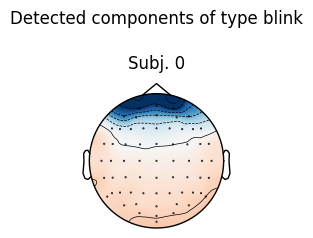

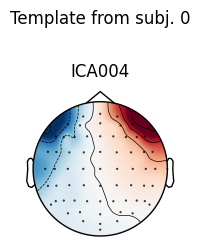

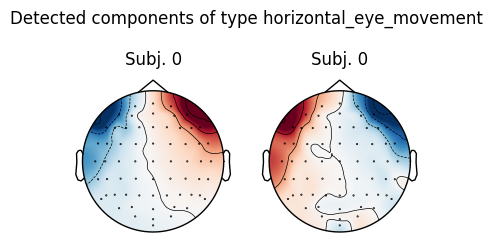

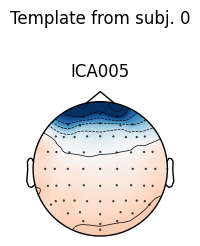

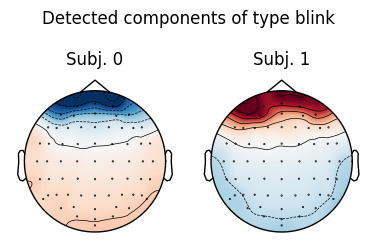

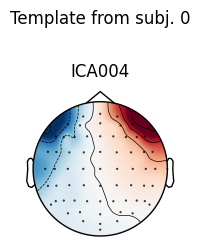

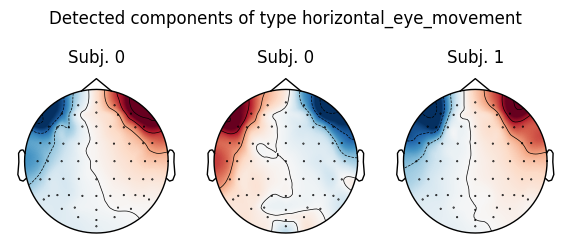

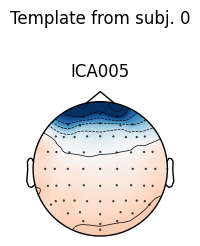

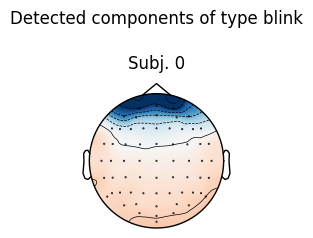

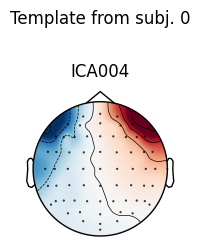

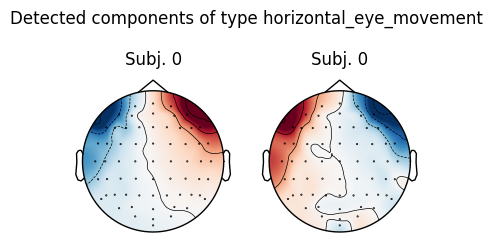

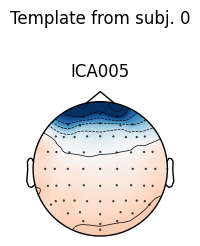

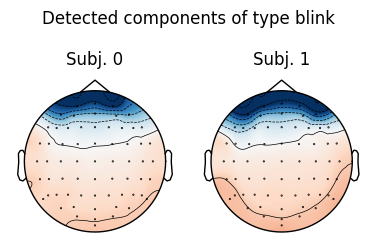

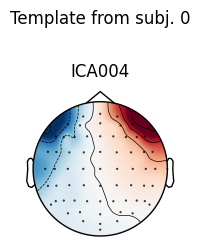

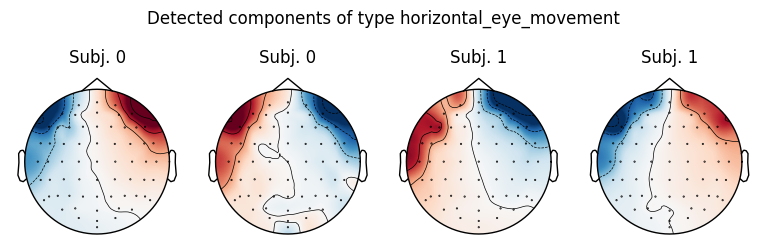

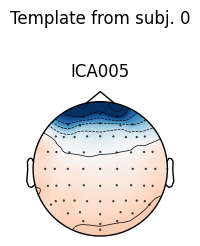

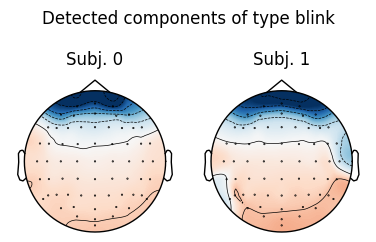

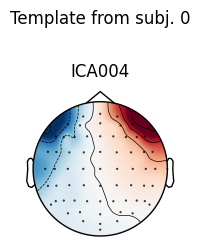

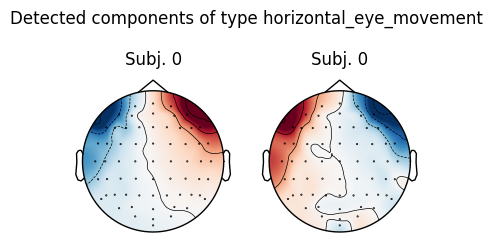

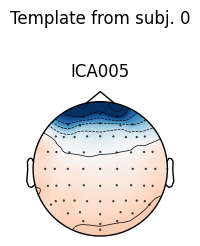

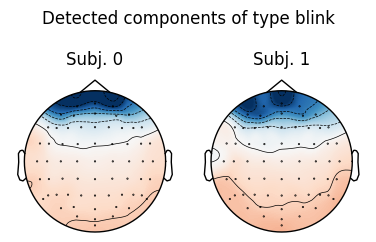

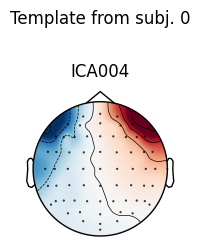

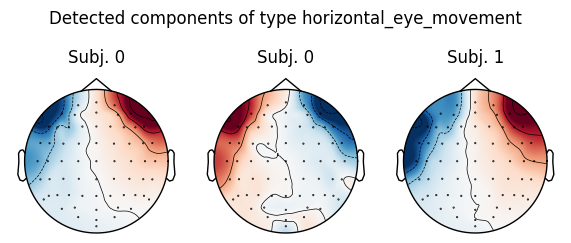

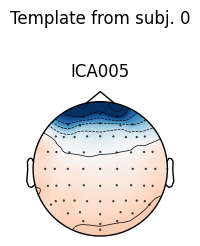

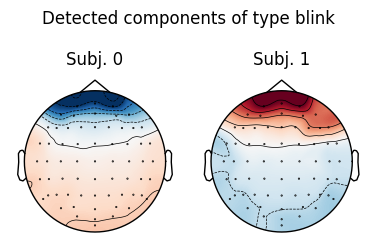

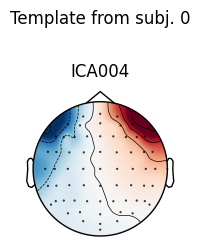

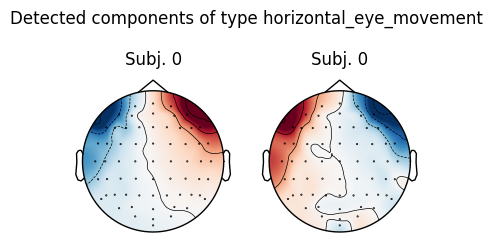

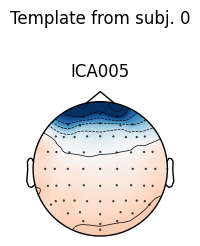

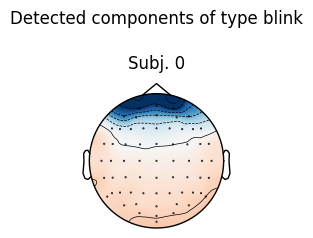

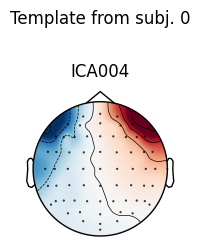

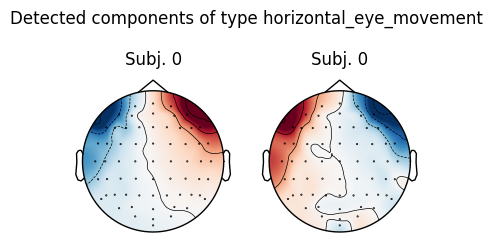

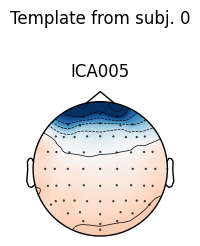

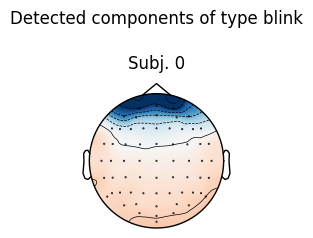

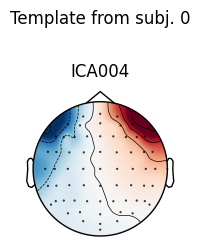

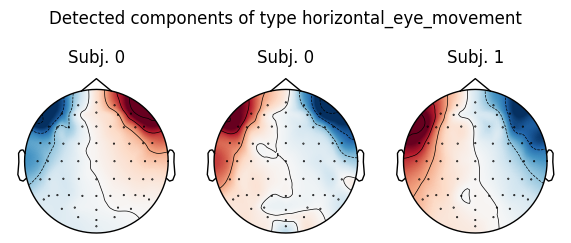

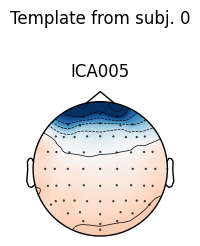

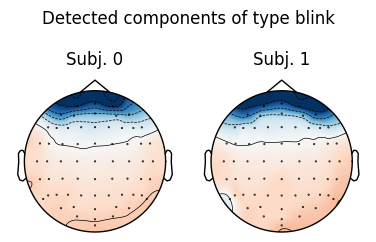

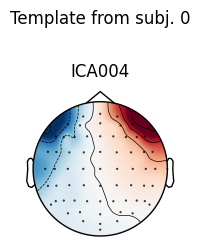

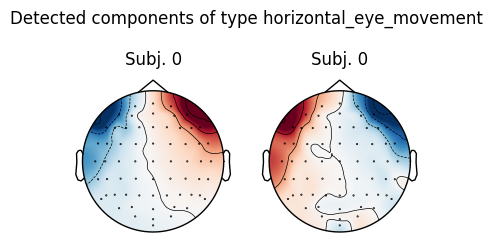

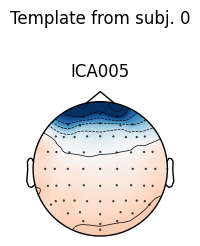

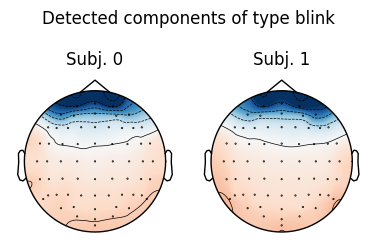

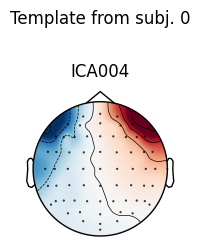

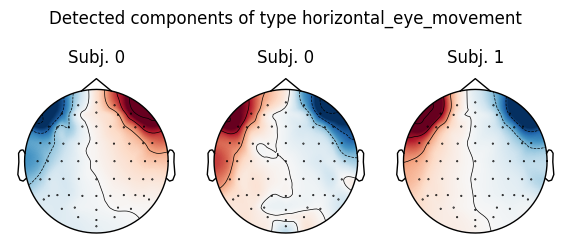

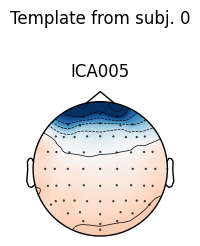

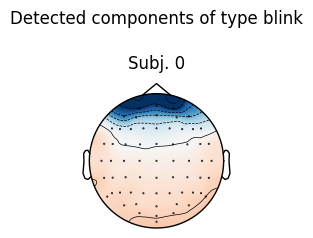

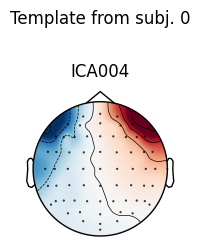

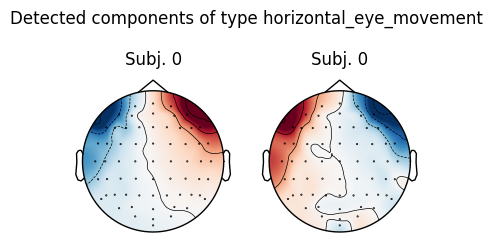

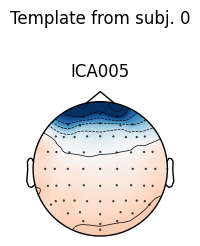

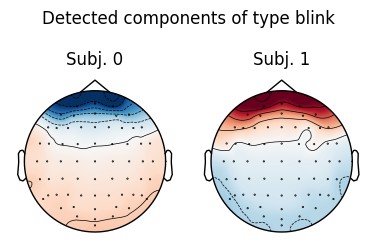

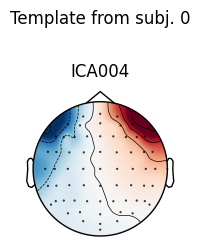

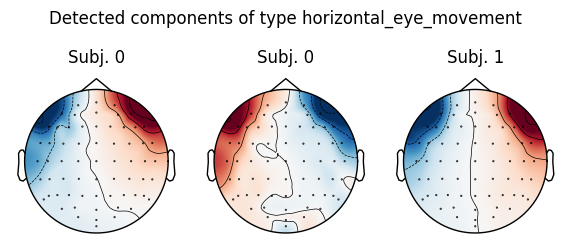

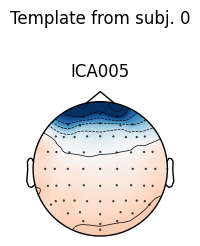

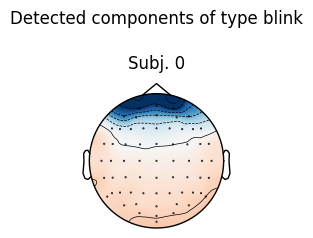

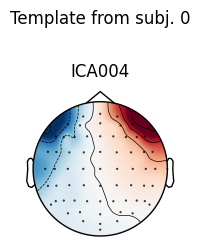

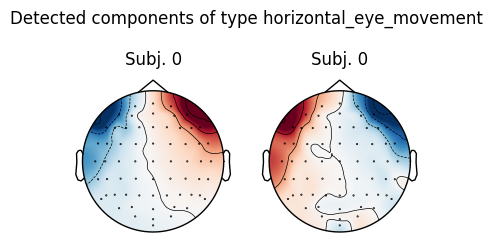

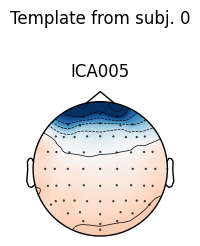

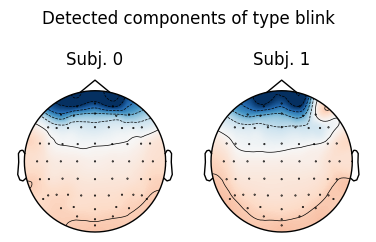

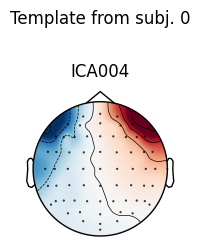

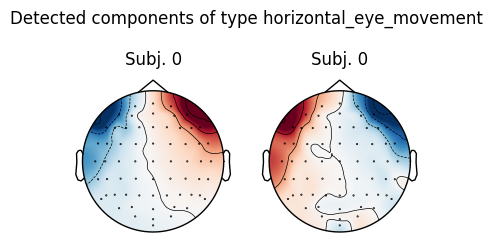

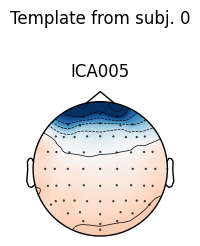

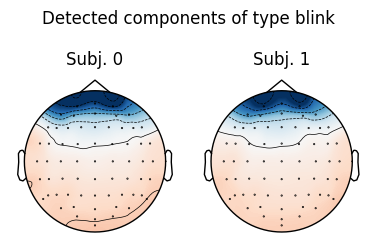

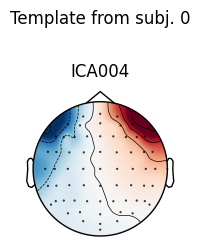

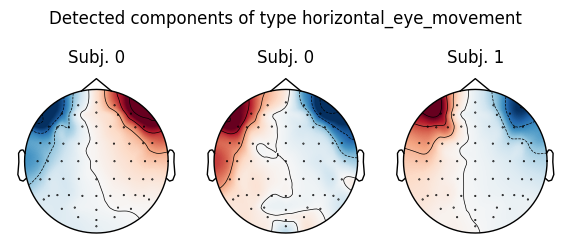

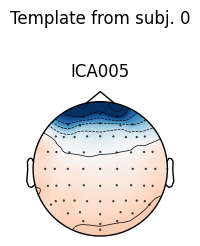

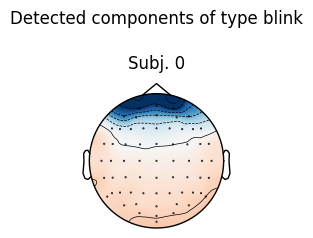

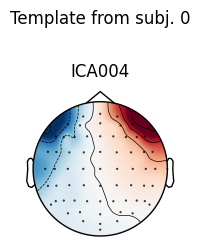

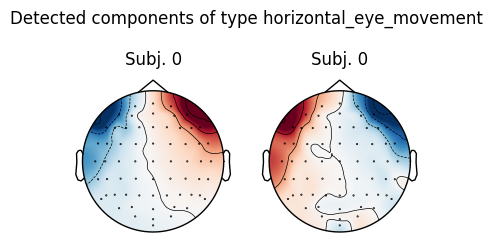

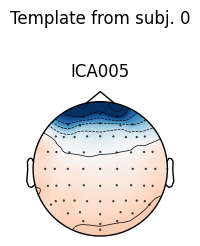

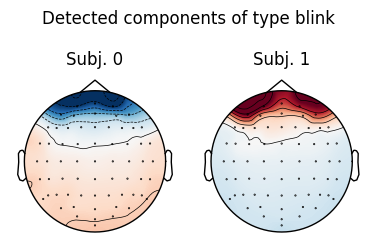

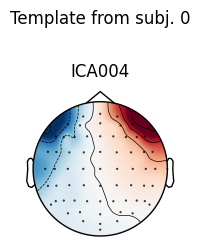

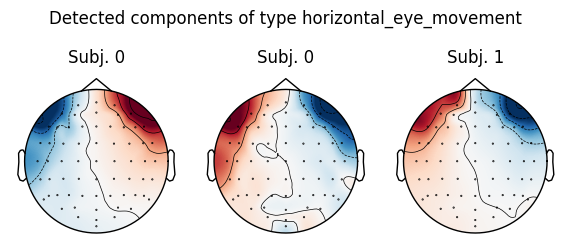

In [7]:
all_dfs = None

ica_epochs_dict = {}
ica_dict = {}
eog_idx_dict = {}
events_dict = {}

for each_file in onlyfiles:
    input_path = data_dir + each_file
    
    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    
    if sbj+ssn == "sbj20ssn03":
        ref_ica = None
    else: 
        ref_ica = ica_dict['sbj20ssn03']
    
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    # event_df = event_data_from_data(rns_data, interrupted_id_sessions=[(13,1), (22,1)])
    event_df = event_data_from_data(rns_data, ts_fixer, remove_id_sessions=remove_sessions, interrupted_id_sessions=interrupted_sessions)
    
    if event_df.empty:
        continue
    
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time

    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'

    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                          value=[1, 2, None])

    # ecg
    post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

    # eye
    # post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,pretrial_period=0,
    #                                               posttrial_period=0,plot_frequency=20, plot_eye_snippet=40, classifiers=['NSLR'])
    if 'Unity_ViveSREyeTracking' in rns_data:
        post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,
                                                      pretrial_period=0, posttrial_period=0, plot_frequency=20, 
                                                      plot_eye_snippet=40, classifiers=['NSLR'])

    # eeg
    post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
                                run_autoreject=True, run_ica=True, save_raw_eeg = True, sbj_session = sbj+ssn, 
                                template_ica = ref_ica, analyze_pre_ica = True)
    
    # motor
    post_processed_event_df, turns_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)
    if motor_events:
        post_processed_event_df = turns_df
    
    events_dict[sbj+ssn] = events
    ica_epochs_dict[sbj+ssn] = epochs
    ica_dict[sbj+ssn] = ica
    eog_idx_dict[sbj+ssn] = eog_idx
    
    # save data for later use
    if save_data_pkl:
        
        with open('../output/saved_files/corrected_timestamp/all_events.pickle', 'wb') as handle_events:
            pickle.dump(events_dict, handle_events, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/corrected_timestamp/ica_epochs.pickle', 'wb') as handle_ica_eps:
            pickle.dump(ica_epochs_dict, handle_ica_eps, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/corrected_timestamp/ica.pickle', 'wb') as handle_ica:
            pickle.dump(ica_dict, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
        with open('../output/saved_files/corrected_timestamp/eog_comp.pickle', 'wb') as handle_eog:
            pickle.dump(eog_idx_dict, handle_eog, protocol=pickle.HIGHEST_PROTOCOL)

    # save
    post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)
    

In [9]:
print("done")

done


In [8]:
# from pivottablejs import pivot_ui
all_dfs.to_csv(f"../output/saved_files/corrected_timestamp/all_results.csv")
all_dfs.to_excel(f"../output/saved_files/corrected_timestamp/all_results.xlsx")
# all_dfs.to_excel(f"{output_dir}all_results.xlsx")
# pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

### Epoching Raw EEG Data

In [10]:
# load raw eeg.fif file and epoch raw eeg

if epoch_raw_eeg:

    with open('../output/saved_files/corrected_timestamp/all_events.pickle', 'rb') as handle:
        all_events = pickle.load(handle)

    raw_eeg_dir = '../output/saved_files/raw_eeg/'
    event_dict = dict(easy=1, hard=2)

    raw_eeg_dict = {}
    raw_epochs_dict = {}

    for sbj_ssn in list(all_events.keys()):

        each_raw_eeg = sbj_ssn + '_eeg_filt_raw.fif'
        raw_eeg_path = raw_eeg_dir+each_raw_eeg
        raw_eeg = mne.io.read_raw_fif(raw_eeg_path, preload=True)
        raw_eeg_dict[sbj_ssn] = raw_eeg

        epochs_raw = mne.Epochs(raw_eeg, all_events[sbj_ssn], event_id=event_dict, baseline = (None, 0), tmin= -.2, tmax=3, preload=True, on_missing='warn')

        autoreject_epochs = 20
        run_autoreject = True

        if len(epochs_raw) < 10: # we need at least 10 epochs to run autoreject for cross validation
            # bad_epochs_raw = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
            # event_df = event_df.join(bad_epochs)
            reject_log = None
        elif run_autoreject:
            ar_raw = autoreject.AutoReject(random_state=11,n_jobs=1, verbose=False)
            ar_raw.fit(epochs_raw[:autoreject_epochs])  # fit on a few epochs to save time
            epochs_ar, reject_log = ar_raw.transform(epochs_raw, return_log=True)
            # bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
            # event_df = event_df.join(bad_epochs_raw) # creates nan if not processed at all
            epochs_raw = epochs_ar

        raw_epochs_dict[sbj_ssn] = epochs_raw

    with open('../output/saved_files/corrected_timestamp/raw_epochs.pickle', 'wb') as handle_raw_eps:
        pickle.dump(raw_epochs_dict, handle_raw_eps, protocol=pickle.HIGHEST_PROTOCOL)
    with open('../output/saved_files/corrected_timestamp/raw_eeg.pickle', 'wb') as handle_raw_eeg:
        pickle.dump(raw_eeg_dict, handle_raw_eeg, protocol=pickle.HIGHEST_PROTOCOL)


Opening raw data file ../output/saved_files/raw_eeg/sbj20ssn03_eeg_filt_raw.fif...
    Range : 0 ... 212496 =      0.000 ...  1660.125 secs
Ready.
Reading 0 ... 212496  =      0.000 ...  1660.125 secs...
Not setting metadata
35 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 411 original time points ...
0 bad epochs dropped
Opening raw data file ../output/saved_files/raw_eeg/sbj14ssn03_eeg_filt_raw.fif...
    Range : 0 ... 180126 =      0.000 ...  1407.234 secs
Ready.
Reading 0 ... 180126  =      0.000 ...  1407.234 secs...
Not setting metadata
33 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 411 original time points ...
0 bad epochs dropped
Dropped 2 epochs: 0, 8
Opening raw data file ../output/saved_f

### Load All Processed Data and Dataframe

In [ ]:
all_dfs = pd.read_csv("../output/saved_files/corrected_timestamp/all_results.csv")

# open saved pickle files
with open('../output/saved_files/corrected_timestamp/ica_epochs.pickle', 'rb') as handle:
    all_proc_epochs = pickle.load(handle)
with open('../output/saved_files/corrected_timestamp/ica.pickle', 'rb') as handle:
    all_ica = pickle.load(handle)
with open('../output/saved_files/corrected_timestamp/eog_comp.pickle', 'rb') as handle:
    all_eog_comps = pickle.load(handle)
with open('../output/saved_files/corrected_timestamp/raw_epochs.pickle', 'rb') as handle:
    all_raw_epochs = pickle.load(handle)

# save ICA components plot
if save_ica_plts:
    ica_comp_dir = "../output/plots/ica_comps/"
    if not os.path.isdir(ica_comp_dir): os.makedirs(ica_comp_dir)

    for sbj_ssn in list(all_ica.keys()):
        
        all_ica[sbj_ssn].plot_components(picks = list(range(0,20)), title=sbj_ssn+"_ICA_Components", show=False)

        plt.savefig(f"{ica_comp_dir}{sbj_ssn}_ica_comps.png")
        plt.close()

In [ ]:
# Removed component for all sessions

show_removed_comp = False

if show_removed_comp:
    for sbj in all_ica.keys():
        if all_eog_comps[sbj] != []:

            all_ica[sbj].plot_components(picks = all_eog_comps[sbj], title=sbj, show=False)

            plt.savefig(f"../output/plots/Removed_Components_Corrmap/{sbj}_removed_components.png")
            plt.close()
        else:
            pass
    
# all_eog_comps.values()

In [ ]:
# Concatenating all epochs
raw_epochs_concat = mne.concatenate_epochs(list(all_raw_epochs.values()))
proc_epochs_concat = mne.concatenate_epochs(list(all_proc_epochs.values()))

# get EEG data and labels from concatenated epoch objects
raw_epochs_eeg = raw_epochs_concat.get_data()
proc_epochs_eeg = proc_epochs_concat.get_data()

raw_labels = raw_epochs_concat.events[:,2]
proc_labels = proc_epochs_concat.events[:,2]

In [ ]:
# raw_epochs_concat['easy'].plot(n_epochs=5, n_channels=3)
# raw_epochs_concat['hard'].plot(n_epochs=5, n_channels=3)
# proc_epochs_concat['easy'].plot(n_epochs=5, n_channels=3)
# proc_epochs_concat['hard'].plot(n_epochs=5, n_channels=3)

In [ ]:
# sorted_raw_epoch = dict(sorted(all_raw_epochs.items()))
# sorted_proc_epoch = dict(sorted(all_proc_epochs.items()))

# raw_epochs_train = mne.concatenate_epochs(list(sorted_raw_epoch.values())[:-4]).get_data()
# raw_epochs_test = mne.concatenate_epochs(list(sorted_raw_epoch.values())[-4:]).get_data()
# proc_epochs_train = mne.concatenate_epochs(list(sorted_proc_epoch.values())[:-4]).get_data()
# proc_epochs_test = mne.concatenate_epochs(list(sorted_proc_epoch.values())[-4:]).get_data()
# all_raw_epochs

### Time-Frequency Analysis

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = raw_epochs_concat['easy'][20]
epochs_hard = raw_epochs_concat['hard'][20]

# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

sel_chan = 15

# power_easy.plot_topo(baseline=(-0.5, -.2), mode='mean', title='Average power')
# power_easy.plot([sel_chan], baseline=(-3.2, -3), mode='mean', title=power_easy.ch_names[sel_chan])
power_easy.plot([sel_chan], baseline=(-, mode='mean', title=power_easy.ch_names[sel_chan])
# power_easy.plot([sel_chan], baseline=None, mode='mean', title=power_easy.ch_names[sel_chan])

# power_hard.plot_topo(baseline=None, mode='mean', title='Average power')
power_hard.plot([sel_chan], baseline=None, mode='mean', title=power_hard.ch_names[sel_chan])
# power_hard.plot([sel_chan], baseline=None, mode='mean', title=power_hard.ch_names[sel_chan])

## 5. Spoken Difficulty Classification

### Feature Extraction and Classification (All Participants)

In [ ]:
all_dfs_cleaned_up = all_dfs.copy()
all_dfs_cleaned_up = clean_up_adadrive_trials(all_dfs_cleaned_up)

In [ ]:
## EEG Features Extraction
raw_eeg_features, raw_data_features, raw_labels = eeg_features(all_dfs_cleaned_up, 'raw')
processed_eeg_features, processed_data_features, processed_labels = eeg_features(all_dfs_cleaned_up, 'processed')

# raw_selected_channel_bp, raw_selected_data_features, raw_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'raw')
# processed_selected_channel_bp, processed_selected_data_features, processed_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'processed')


In [ ]:
## EEG Features Normalization and Data Split
raw_train_norm, raw_test_norm, proc_train_norm, proc_test_norm, y_train_raw, y_test_raw, y_train_proc, y_test_proc = feature_normalization(
                                                        processed_data_features, processed_labels, raw_data_features, raw_labels)

In [ ]:
# raw_train_norm, raw_test_norm, proc_train_norm, proc_test_norm, y_train_raw, y_test_raw, y_train_proc, y_test_proc

In [ ]:
# np.sum(y_train_proc==2),np.sum(y_train_proc==1), np.sum(y_test_proc==2),np.sum(y_test_proc==1)

In [ ]:
# Trial Difficulty Classification - Raw EEG 
AUC_train_raw, AUC_test_raw, coefs_raw = trial_classification(raw_train_norm, raw_test_norm,
                                                                          y_train_raw, y_test_raw, 
                                                                          'random_forest', 'raw')

In [ ]:
# Trial Difficulty Classification - Artifacts Removed EEG
AUC_train_proc, AUC_test_proc, coefs_proc = trial_classification(proc_train_norm, proc_test_norm,
                                                                             y_train_proc, y_test_proc, 
                                                                             'random_forest', 'processed')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_proc:.2f} \n"
#       f"Training Label:      {y_train_proc} \n"
#       f"Training Prediction: {train_pred_proc} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_proc:.2f} \n"
#       f"Test Label:      {y_test_proc} \n"
#       f"Test Prediction: {test_pred_proc}")

### Important Features Table Generation

In [ ]:
# Generate table for feature importance

# features_list = list(processed_selected_channel_bp.columns)
features_list = list(processed_eeg_features.columns)
features_list.extend(["Left Pupil Diameter","Right Pupil Diameter"])

bottom_10_raw = zip(np.argsort(coefs_raw)[:10], np.sort(coefs_raw)[:10])
bottom_10_raw_features = [features_list[i] + f" - {importance:.2E}" for i, importance in bottom_10_raw]
top_10_raw =  zip(np.argsort(coefs_raw)[-10:], np.sort(coefs_raw)[-10:])
top_10_raw_features = [features_list[i] + f" - {importance:.2E}" for i, importance in top_10_raw]


bottom_10_proc = zip(np.argsort(coefs_proc)[:10], np.sort(coefs_proc)[:10])
bottom_10_proc_features = [features_list[i] + f" - {importance:.2E}" for i, importance in bottom_10_proc]
top_10_proc = zip(np.argsort(coefs_proc)[-10:],np.sort(coefs_proc)[-10:])
top_10_proc_features = [features_list[i] + f" - {importance:.2E}" for i, importance in top_10_proc]

features_ranking = {
    'Top 10 features for raw filtered data': top_10_raw_features,
    'Bottom 10 features for raw filtered data': bottom_10_raw_features,
    'Top 10 features for ICA processed raw filtered data': top_10_proc_features,
    'Bottom 10 features for ICA processed raw filtered data': bottom_10_proc_features
}

df_features = pd.DataFrame(features_ranking, index = ['Low End','2','3','4','5','6','7','8','9','High End'])
# df_features.to_excel(f"{output_dir}saved_files/ranked_features_all.xlsx")
df_features.to_csv(f"{output_dir}saved_files/ranked_features_all.csv")

# print (len(top_10_raw_features),len(bottom_10_raw_features), len(top_10_proc_features), len(bottom_10_proc_features))

In [ ]:
# df_features

### Within participant classification (Spoken Difficulty)

In [ ]:
selected_clf = 'random_forest'
participants_id = np.sort(all_dfs_cleaned_up.ppid.unique().astype(int)) 

participant_AUC = np.empty([len(participants_id),4])

for i, participant in enumerate(participants_id):
    single_sbj_df = all_dfs_cleaned_up[all_dfs_cleaned_up.ppid == participant]
    
    if np.sum((single_sbj_df['spoken_difficulty']=='easy') | (single_sbj_df['spoken_difficulty']=='hard')) < 10:
        AUC_train_raw = AUC_test_raw = AUC_train_proc = AUC_test_proc = float('NaN')
    else:
        raw_eeg_features, raw_data_features, raw_labels = eeg_features(single_sbj_df, 'raw')
        processed_eeg_features, processed_data_features, processed_labels = eeg_features(single_sbj_df, 'processed')

        raw_train_norm, raw_test_norm, proc_train_norm, proc_test_norm, y_train_raw, y_test_raw, y_train_proc, y_test_proc = feature_normalization(
                                                            processed_data_features, processed_labels, raw_data_features, raw_labels, train_percentage = 0.9)

        AUC_train_raw, AUC_test_raw, coefs_raw = trial_classification(raw_train_norm, raw_test_norm,
                                                                                  y_train_raw, y_test_raw, 
                                                                                  selected_clf, 'raw', save_plots=False)
        AUC_train_proc, AUC_test_proc, coefs_proc = trial_classification(proc_train_norm, proc_test_norm,
                                                                                     y_train_proc, y_test_proc, 
                                                                                     selected_clf, 'processed', save_plots=False)

    participant_AUC[i,:] = [AUC_train_raw, AUC_test_raw, AUC_train_proc, AUC_test_proc]

participant_AUC_df = pd.DataFrame(participant_AUC, index = participants_id, 
                                  columns = ['Raw Train AUC', 'Raw Test AUC', 'ICA Processed Train AUC', 'ICA Processed Test AUC'])

participant_AUC_df

## 6.1 Motor Events Classfication

### Data Processing and Extraction

In [6]:
motor_output_dir = (f"../output/batch_analysis/")

In [7]:
import glob
import re

def str_list_to_list(lst):
    str_single_space = re.sub("\s+", " ", lst.strip())
    str_no_brackets = re.sub("[\[\]]", "", lst)
    return [float(n) for n in str_no_brackets.split()]

# loop over the list of csv files
def read_motor_csvs():
    csv_files = glob.glob(os.path.join(motor_output_dir, "ppid*_motor.csv"))
    all_dfs = None
    for f in csv_files:
        # read the csv file and add column for labels
        temp_df = pd.read_csv(f)

        all_steer_events = temp_df.copy()['post_steer_event_raw']
        all_steer_events_finalized = all_steer_events.apply(str_list_to_list)

        norm_pos = lambda wheel_pos: np.asarray(wheel_pos)/np.asarray(wheel_pos[0])
        final_pos = lambda final_wheel_pos: np.asarray(final_wheel_pos[-1])-np.asarray(final_wheel_pos[0])

        norm_pos_df = all_steer_events_finalized.apply(norm_pos)

        temp_df['Steer_Wheel_Degree'] = abs(all_steer_events_finalized.apply(final_pos))
        temp_df['Steer_Wheel_Degree_Categorical'] = pd.qcut(temp_df['Steer_Wheel_Degree'], 2, labels=["Low", "High"]) #2=High, 1 =Low
        temp_df['Steer_Wheel_Degree_Encoded'] = temp_df.Steer_Wheel_Degree_Categorical.replace({'High': 2, 'Low': 1})
        # temp_df['Mean_Steer_Wheel_Degree'] = temp_df.Steer_Wheel_Degree.mean()
        
        if not type(all_dfs)==pd.core.frame.DataFrame:
            all_dfs = temp_df
        else:
            all_dfs = pd.concat([all_dfs, temp_df], ignore_index=True)
    all_dfs = all_dfs[all_dfs.columns.drop(list(all_dfs.filter(regex='Unnamed')))]
    
    all_dfs['Mean_Steer_Wheel_Degree'] = all_dfs.Steer_Wheel_Degree.mean()
    return all_dfs

In [8]:
all_dfs_all_pp_trials = read_motor_csvs()
motor_all_dfs = all_dfs_all_pp_trials.copy()

motor_all_dfs['sub_sess'] = motor_all_dfs.ppid.astype(str) + "_" + motor_all_dfs.session.astype(str)
motor_all_dfs = motor_all_dfs.loc[~motor_all_dfs.sub_sess.isin([f"{es[0]}.0_{es[1]}.0" for es in remove_sessions])]

In [9]:
motor_all_dfs = clean_up_adadrive_trials(motor_all_dfs)

In [10]:
# all_steer_events = motor_all_dfs['post_steer_event_raw']
# all_steer_events_finalized = all_steer_events.apply(str_list_to_list)

# norm_pos = lambda wheel_pos: np.asarray(wheel_pos)/np.asarray(wheel_pos[0])
# final_pos = lambda final_wheel_pos: np.asarray(final_wheel_pos[-1])-np.asarray(final_wheel_pos[0])

# motor_all_dfs['post_steer_event_norm'] = all_steer_events_finalized.apply(norm_pos)
# motor_all_dfs['Steer_Wheel_Degree'] = abs(all_steer_events_finalized.apply(final_pos))
# motor_all_dfs['Steer_Wheel_Degree_Categorical'] = pd.qcut(motor_all_dfs['Steer_Wheel_Degree'], 2, labels=["Low", "High"]) #2=High, 1 =Low
# motor_all_dfs['Steer_Wheel_Degree_Encoded'] = motor_all_dfs.Steer_Wheel_Degree_Categorical.replace({'High': 2, 'Low': 1})

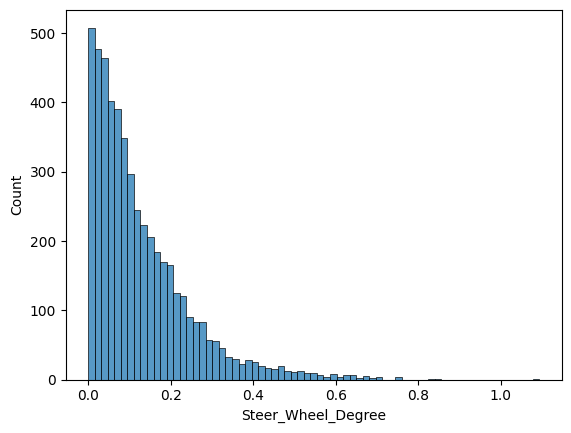

In [11]:
sns.histplot(data=motor_all_dfs, x="Steer_Wheel_Degree")
plt.savefig(f"../output/plots/steering_wheel_turned_deg.png", dpi=300)

In [12]:
# motor_all_dfs.to_csv(f"../output/batch_analysis/motor_df_label.csv")
# motor_all_dfs.to_excel(f"../output/batch_analysis/motor_df_label.xlsx")

### Feature Extraction and Classification (All Participants)

In [ ]:
# alpha_power, beta_power, theta_hjorth_activity, theta_hfd, theta_power, theta_sample_entropy,
# theta_hjorth_mobility, alpha_hjorth_activity, alpha_sample_entropy, alpha_hfd, beta_hjorth_activity,
# beta_hjorth_activity, gamma_power, gamma_hjorth_activity, beta_hfd, beta_hjorth_complexity,
# beta_hjorth_mobility, alpha_hjorth_mobility, gamma_hfd, alpha_hjorth_complexity,
# theta_hjorth_complexity, beta_sample_entropy, gamma_hjorth_mobility, gamma_hjorth_complexity,
# gamma_sample_entropy

In [16]:
selected_feature = '8-15_Hz_Power|15-32_Hz_Power|4-8_Hz_Hjorth_Activity|4-8_Hz_Higuchi_FD|4-8_Hz_Power|4-8_Hz_Sample_entropy|4-8_Hz_Hjorth_Mobility|8-13_Hz_Hjorth_Activity|8-13_Hz_Sample_entropy| 8-13_Hz_Higuchi_FD'

processed_eeg_features, processed_data_features, processed_labels = eeg_features(motor_all_dfs, 'processed', 
                                                                                 selected_chans = False, features = 'all',
                                                                                 label_source = 'Steer_Wheel_Degree_Encoded')

In [17]:
_, _, proc_train_norm, proc_test_norm, _, _, y_train_proc, y_test_proc = feature_normalization(processed_data_features,
                                                                                               processed_labels,
                                                                                               raw_feature = None, 
                                                                                               raw_labels = None)

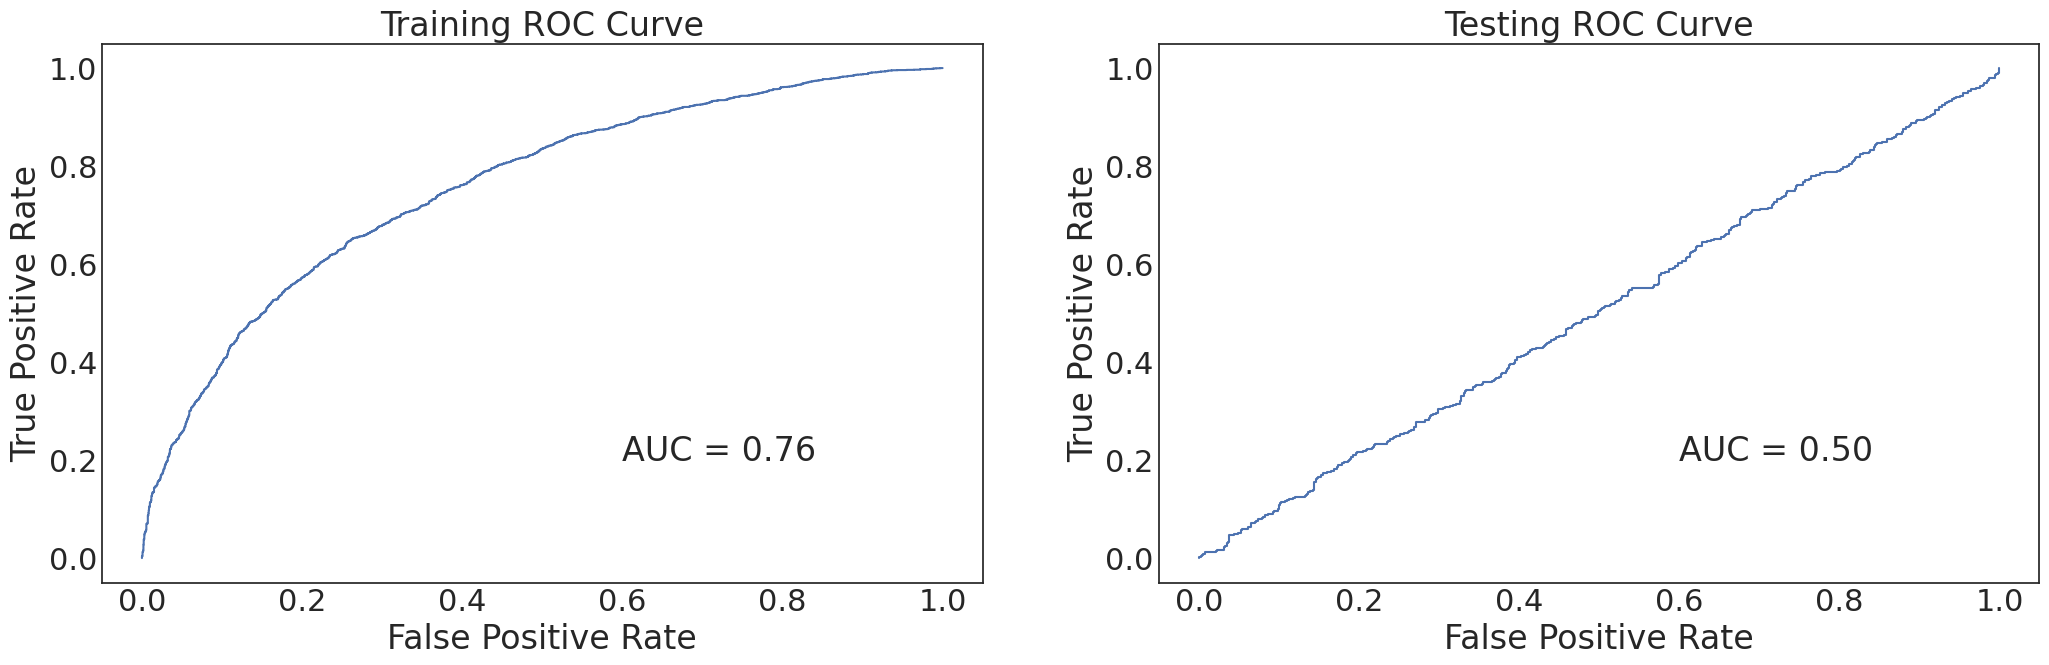

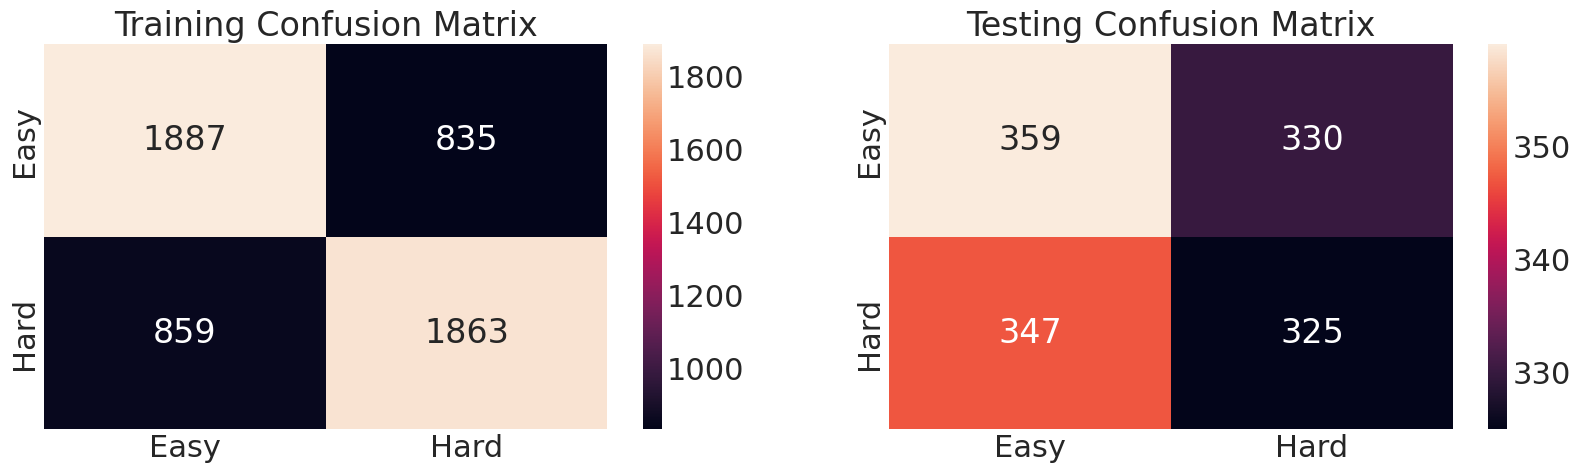

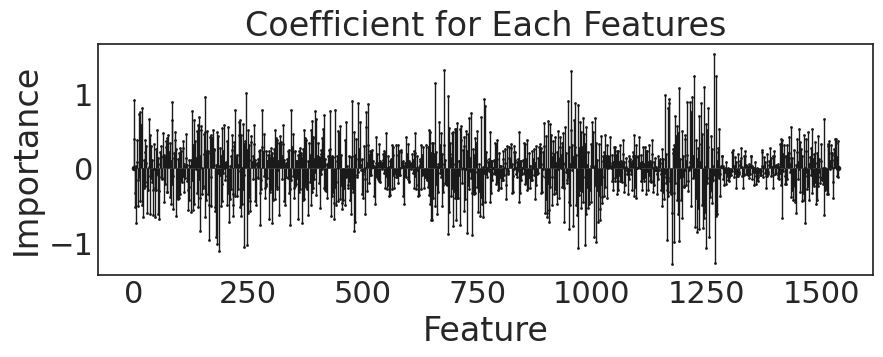

In [18]:
AUC_train_proc, AUC_test_proc, coefs_proc = trial_classification(proc_train_norm, proc_test_norm,
                                                                             y_train_proc, y_test_proc, 
                                                                             'logistic', 'processed')

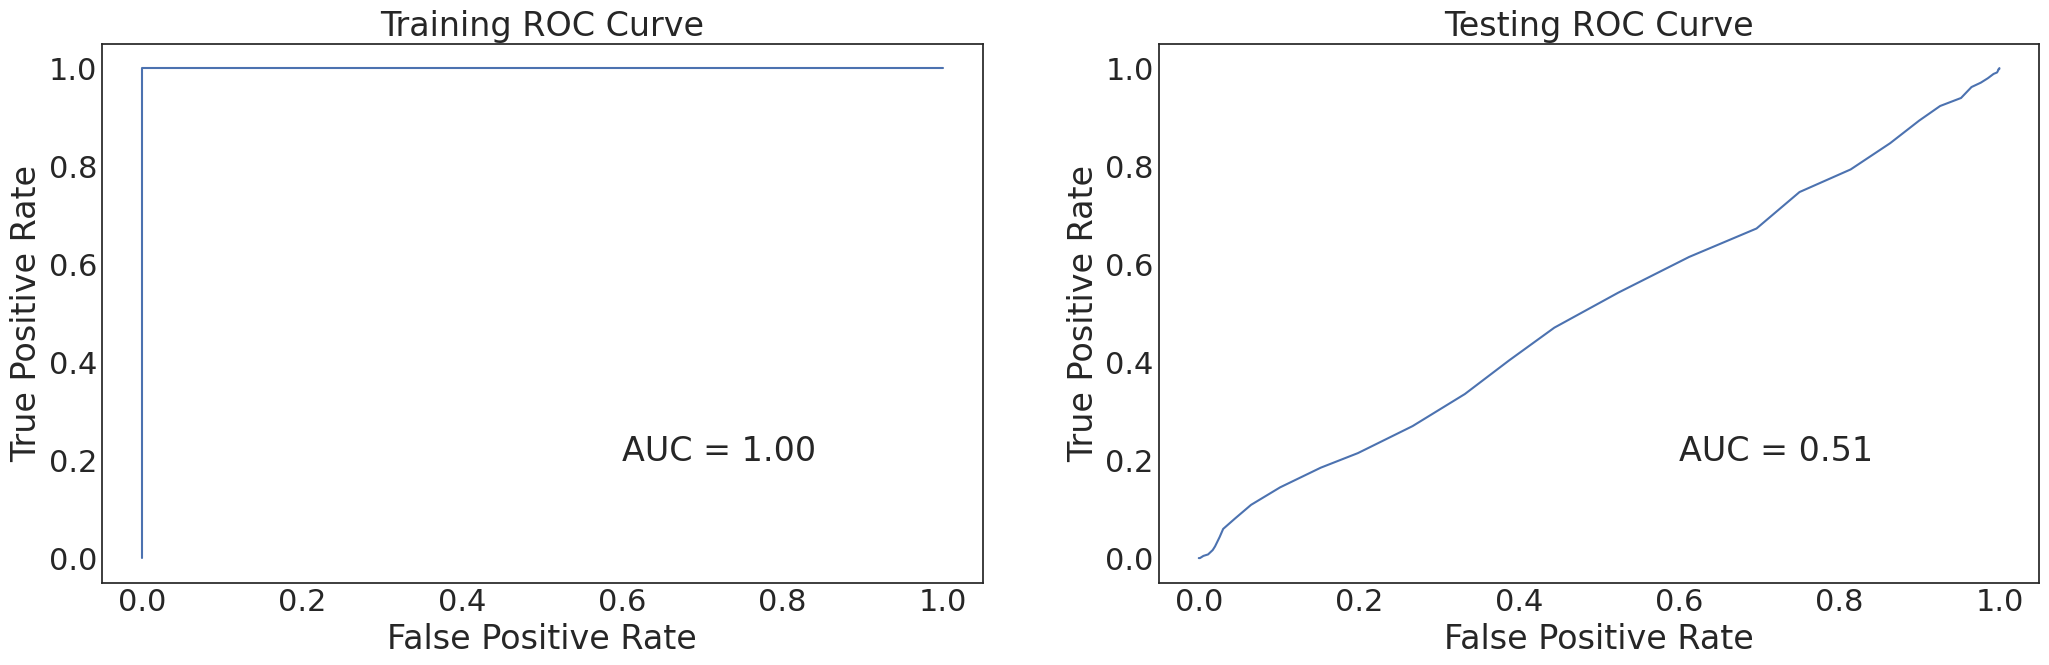

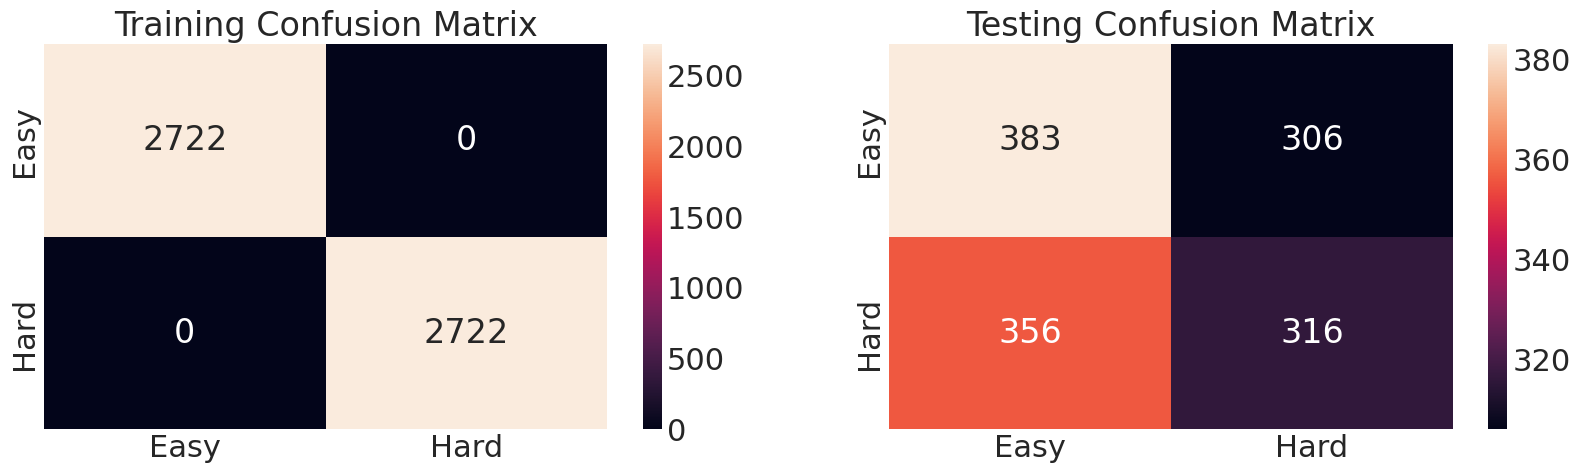

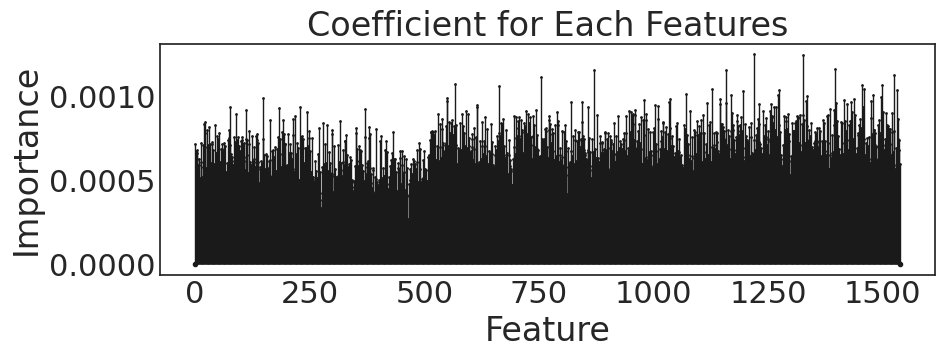

In [19]:
AUC_train_proc, AUC_test_proc, coefs_proc = trial_classification(proc_train_norm, proc_test_norm,
                                                                             y_train_proc, y_test_proc, 
                                                                             'random_forest', 'processed')

### Within Participant Classification (Steering Wheel Position Difference)

In [ ]:
selected_clf = 'random_forest'
participants_id = np.sort(motor_all_dfs.ppid.unique().astype(int)) 

participant_AUC = np.empty([len(participants_id),2])

for i, participant in enumerate(participants_id):
    single_sbj_df = motor_all_dfs[motor_all_dfs.ppid == participant]

    processed_eeg_features, processed_data_features, processed_labels = eeg_features(single_sbj_df, 'processed',
                                                                                    label_source = 'Steer_Wheel_Degree_Encoded')

    _, _, proc_train_norm, proc_test_norm, _, _, y_train_proc, y_test_proc = feature_normalization(processed_data_features, 
                                                                                                   processed_labels, 
                                                                                                   raw_feature = None, 
                                                                                                   raw_labels = None)

    AUC_train_proc, AUC_test_proc, coefs_proc = trial_classification(proc_train_norm, proc_test_norm,
                                                                     y_train_proc, y_test_proc, 
                                                                     selected_clf, 'processed', save_plots=False)

    participant_AUC[i,:] = [AUC_train_proc, AUC_test_proc]


participant_AUC_df = pd.DataFrame(participant_AUC, index = participants_id, 
                                  columns = ['ICA Processed Train AUC', 'ICA Processed Test AUC'])

In [ ]:
participant_AUC_df

## 6.2 Motor Event Regression

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=rs)

In [14]:
def cal_rmse(df, true_val_col = 'Steer_Wheel_Degree', eeg_features_list = 'all', 
             eye_features_list = 'all', ecg_features_list = 'all'):
    
    if eeg_features == 'all':
        # all eeg features rmse calculation
        x_eeg, _, _ = eeg_features(df, 'processed', label_source = 'Steer_Wheel_Degree_Encoded')
    else:
        # selected eeg features rmse calculation
        # selected_feature = '8-15_Hz_Power|15-32_Hz_Power|4-8_Hz_Hjorth_Activity|4-8_Hz_Higuchi_FD|4-8_Hz_Power|4-8_Hz_Sample_entropy|4-8_Hz_Hjorth_Mobility|8-13_Hz_Hjorth_Activity|8-13_Hz_Sample_entropy| 8-13_Hz_Higuchi_FD'
        selected_feature = "|".join(map(str,eeg_features_list))
        x_eeg, _, _ = eeg_features(df, 'processed', features = selected_feature, label_source = 'Steer_Wheel_Degree_Encoded')
        y_eeg = df[true_val_col]
        
    X_eeg_train, X_eeg_test, y_eeg_train, y_eeg_test = train_test_split(x_eeg, y_eeg, test_size=0.3, random_state=rs)
    regr.fit(X_eeg_train, y_eeg_train)

    y_eeg_pred = regr.predict(X_eeg_test)
    eeg_rmse = mean_squared_error(y_eeg_test, y_eeg_pred, squared=False)
    
    # eye rmse calculation
    if eye_features_list == 'all':
        eye_features = ["Left Pupil Diameter", "Right Pupil Diameter",
                   "Left Evoked Pupil Diameter", "Right Evoked Pupil Diameter", true_val_col]
    else:
        eye_features = eye_features_list
        eye_features.append(true_val_col)
     
    eye_df = df[eye_features].dropna()
    x_eye = eye_df.iloc[:,0:-1]
    y_eye = eye_df.iloc[:,-1]
    X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(x_eye, y_eye, test_size=0.3, random_state=rs)
    regr.fit(X_eye_train, y_eye_train)

    y_eye_pred = regr.predict(X_eye_test)
    eye_rmse = mean_squared_error(y_eye_test, y_eye_pred, squared=False)
    
    #ecg emse calculation
    if ecg_features_list == 'all':
        ecg_feature_first = df.columns.get_loc("bpm")
        ecg_feature_last = df.columns.get_loc("breathingrate")
        ecg_feature = df.iloc[:,ecg_feature_first:ecg_feature_last-2].join(df[true_val_col])
        ecg_df = ecg_feature.dropna()
    else:
        ecg_feature = ecg_features_list
        ecg_feature.append(true_val_col)
        ecg_df = df[ecg_feature].dropna()
        
    x_ecg = ecg_df.iloc[:,0:-1]
    y_ecg = ecg_df.iloc[:,-1]
    X_ecg_train, X_ecg_test, y_ecg_train, y_ecg_test = train_test_split(x_ecg, y_ecg, test_size=0.3, random_state=rs)

    regr.fit(X_ecg_train, y_ecg_train)
    y_ecg_pred = regr.predict(X_ecg_test)
    ecg_rmse = mean_squared_error(y_ecg_test, y_ecg_pred, squared=False)
    
    # return (y_eeg_all_test, y_eeg_all_pred, eeg_rmse_all, 
    #         y_eeg_test, y_eeg_pred, eeg_rmse_selected, 
    #         y_eye_test, y_eye_pred, eye_rmse, 
    #         y_ecg_test, y_ecg_pred, ecg_rmse)
    return (y_eeg_test, y_eeg_pred, eeg_rmse, 
        y_eye_test, y_eye_pred, eye_rmse, 
        y_ecg_test, y_ecg_pred, ecg_rmse)

In [15]:
(y_eeg_test_mean, y_eeg_pred_mean, eeg_rmse_mean, 
            y_eye_test_mean, y_eye_pred_mean, eye_rmse_mean, 
            y_ecg_test_mean, y_ecg_pred_mean, ecg_rmse_mean) = cal_rmse(motor_all_dfs, true_val_col = 'Mean_Steer_Wheel_Degree',
                                                                       eeg_features_list = ['F1_15-32_Hz_Power'],
                                                                       eye_features_list = ['Left Pupil Diameter'],
                                                                       ecg_features_list = ['sdnn'])

In [16]:
(y_eeg_test, y_eeg_pred, eeg_rmse, 
            y_eye_test, y_eye_pred, eye_rmse, 
            y_ecg_test, y_ecg_pred, ecg_rmse) = cal_rmse(motor_all_dfs, true_val_col = 'Steer_Wheel_Degree',
                                                        eeg_features_list = ['F1_15-32_Hz_Power'],
                                                        eye_features_list = ['Left Pupil Diameter'],
                                                        ecg_features_list = ['sdnn'])

In [17]:
eeg_rmse_mean, eye_rmse_mean, ecg_rmse_mean, eeg_rmse, eye_rmse, ecg_rmse

(5.495603971894525e-15,
 5.384581669432009e-15,
 5.384581669432009e-15,
 0.14716326552153838,
 0.14441097220298366,
 0.14741885213260192)

In [ ]:
# x_eeg_all, _, _ = eeg_features(motor_all_dfs, 'processed', selected_chans = False, 
#                            features = 'all', label_source = 'Steer_Wheel_Degree_Encoded')
# y_eeg_all = motor_all_dfs.Mean_Steer_Wheel_Degree
# X_eeg_all_train, X_eeg_all_test, y_eeg_all_train, y_eeg_all_test = train_test_split(x_eeg_all, y_eeg_all, test_size=0.3, random_state=rs)
# regr.fit(X_eeg_all_train, y_eeg_all_train)

# y_eeg_all_pred = regr.predict(X_eeg_all_test)
# eeg_rmse_all = mean_squared_error(y_eeg_all_test, y_eeg_all_pred, squared=False)

# ###
# selected_feature = '8-15_Hz_Power|15-32_Hz_Power|4-8_Hz_Hjorth_Activity|4-8_Hz_Higuchi_FD|4-8_Hz_Power|4-8_Hz_Sample_entropy|4-8_Hz_Hjorth_Mobility|8-13_Hz_Hjorth_Activity|8-13_Hz_Sample_entropy| 8-13_Hz_Higuchi_FD'

# x_eeg, _, _ = eeg_features(motor_all_dfs, 'processed', selected_chans = True, 
#                            features = selected_feature, label_source = 'Steer_Wheel_Degree_Encoded')
# y_eeg = motor_all_dfs.Mean_Steer_Wheel_Degree
# X_eeg_train, X_eeg_test, y_eeg_train, y_eeg_test = train_test_split(x_eeg, y_eeg, test_size=0.3, random_state=rs)
# regr.fit(X_eeg_train, y_eeg_train)

# y_eeg_pred = regr.predict(X_eeg_test)
# eeg_rmse_selected = mean_squared_error(y_eeg_test, y_eeg_pred, squared=False)

# ### 
# eye_features = ["Left Pupil Diameter", "Right Pupil Diameter",
#                "Left Evoked Pupil Diameter", "Right Evoked Pupil Diameter", "Mean_Steer_Wheel_Degree"]
# eye_df = motor_all_dfs[eye_features].dropna()
# x_eye = eye_df.iloc[:,0:4]
# y_eye = eye_df.iloc[:,-1]
# X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(x_eye, y_eye, test_size=0.3, random_state=rs)
# regr.fit(X_eye_train, y_eye_train)

# y_eye_pred = regr.predict(X_eye_test)
# eye_rmse = mean_squared_error(y_eye_test, y_eye_pred, squared=False)

# ###
# ecg_feature_first = motor_all_dfs.columns.get_loc("measures.bpm")
# ecg_feature_last = motor_all_dfs.columns.get_loc("measures.breathingrate")
# ecg_feature = motor_all_dfs.iloc[:,ecg_feature_first:ecg_feature_last-2].join(motor_all_dfs["Mean_Steer_Wheel_Degree"])
# ecg_df = ecg_feature.dropna()
# x_ecg = ecg_df.iloc[:,0:-1]
# y_ecg = ecg_df.iloc[:,-1]
# X_ecg_train, X_ecg_test, y_ecg_train, y_ecg_test = train_test_split(x_ecg, y_ecg, test_size=0.3, random_state=rs)

# regr.fit(X_ecg_train, y_ecg_train)
# y_ecg_pred = regr.predict(X_ecg_test)
# ecg_rmse = mean_squared_error(y_ecg_test, y_ecg_pred, squared=False)

In [ ]:
rmse_data = [[eeg_rmse_all_mean, eeg_rmse_selected_mean, eye_rmse_mean, ecg_rmse_mean],
        [eeg_rmse_all, eeg_rmse_selected, eye_rmse, ecg_rmse]]
rmse_column = ['EEG prediction RMSE - all features', 'EEG prediction RMSE - selected features', 'Eye prediction RMSE', 'ECG prediction RMSE']
rmse_row = ['Mean', 'Raw']

In [ ]:
rmse_df = pd.DataFrame(rmse_data, index = rmse_row, columns = rmse_column)
rmse_df.to_csv(f'../output/saved_files/all_modality_rmse.csv')
rmse_df.to_excel(f'../output/saved_files/all_modality_rmse.xlsx')

In [ ]:
pred_dict = dict({"EEG_all_Mean_pred": y_eeg_all_pred_mean,
                  "EEG_selected_Mean_pred": y_eeg_pred_mean,  
                  "Eye_Mean_pred": y_eye_pred_mean,
                  "ECG_Mean_pred": y_ecg_pred_mean,
                  "EEG_all_pred": y_eeg_all_pred, 
                  "EEG_selected_pred": y_eeg_pred, 
                  "Eye_pred": y_eye_pred,
                  "ECG_pred": y_ecg_pred, 
                 })

with open('../output/saved_files/pickle_files/modality_pred.pickle', 'wb') as handle_pred:
            pickle.dump(pred_dict, handle_pred, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_dict = dict({"EEG_all_Mean_test": y_eeg_all_test_mean, 
                  "EEG_selected_Mean_test": y_eeg_test_mean, 
                  "Eye_Mean_test": y_eye_test_mean,
                  "ECG_Mean_test": y_ecg_test_mean,
                  "EEG_all_test": y_eeg_all_test, 
                  "EEG_selected_test": y_eeg_test, 
                  "Eye_test": y_eye_test,
                  "ECG_test": y_ecg_test,
                 })

with open('../output/saved_files/pickle_files/modality_test.pickle', 'wb') as handle_test:
            pickle.dump(test_dict, handle_test, protocol=pickle.HIGHEST_PROTOCOL)

## 7. Driving performance (Throttle Input/Braking)

In [ ]:
# new classification label based on wheel input

wheel_input_metric = all_dfs_cleaned_up['abs_sum_delta_throttle_input']/all_dfs_cleaned_up['abs_sum_delta_brake_input']

driving_metric = pd.qcut(wheel_input_metric, 2, labels=["High", "Low"])
driving_metric_df = pd.DataFrame(driving_metric,columns = ['driving_metric'])
all_dfs_cleaned_up = all_dfs_cleaned_up.join(driving_metric_df)

all_dfs_cleaned_up = all_dfs_cleaned_up.replace({'driving_metric':{'High': 2, 'Low': 1}})

## ICA-Adaptive Filter - WIP

In [ ]:
# !pip install EMD_signal
import PyEMD
from PyEMD import EMD, Visualisation

# eeg_comps = ica.get_sources(raw).get_data() #eeg componenets for all epochs
# # eeg_comps = ica.get_sources(epochs).get_data() #eeg componenets for all epochs
# # comps_epoch_concat = np.empty([eeg_comps.shape[1],eeg_comps.shape[2]*eeg_comps.shape[0]]) #initiate empty array
# # for i in range(eeg_comps.shape[0]):
# #     comps_epoch_concat[:,i*eeg_comps.shape[2]:eeg_comps.shape[2]*(i+1)] = eeg_comps[i]

# component_no = 5
# test_comps = eeg_comps[component_no]

# emd = EMD() # EMD instantiation
# emd.emd(test_comps) # decompose signal into IMFs and residue
# imfs, res = emd.get_imfs_and_residue()

# # # imfs = emd(np.squeeze(eeg_comps[0])[0])

In [ ]:
# scipy.stats.kurtosis(test_comps)

In [ ]:
# # Visualization
# t = np.arange(0, 3+1/freq, 1/freq)
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# # vis.plot_instant_freq(t, imfs=imfs)
# vis.show()